# Sentiment Analysis con KNN
## Clasificador en C++ 💪💪
Vamos a probar a nuestro bichito


Definir los path al ejecutable de python 3.6 y sus librerías,
de acuerdo al virtual env que estén corriendo.

In [7]:
!cd .. && git submodule init
!cd .. && git submodule update
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 8.3.0
-- The CXX compiler identification is GNU 8.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/tdelgado/anaconda3/bin/python (found version "3.7.3") 
-- Found PythonLibs: /home/tdelgado/anaconda3/lib/libpython3.7m.so
-- pybind11 v2.3.dev0
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/tdelgado/Desktop/Tp2Metodos
-- Configuring done
-- Generatin

In [8]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import sentiment


/home/tdelgado/Desktop/Tp2Metodos/notebooks
Python 3.7.3


In [9]:
USAR_IMDB_LARGE = False
DATA_SIZE = {}
DATA_SIZE["test"] = 200
DATA_SIZE["train"] = 10000

In [43]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import os

!cd ../data && tar -xvf *.tar.gz

if not USAR_IMDB_LARGE:
    df = pd.read_csv("../data/imdb_small.csv", index_col=0) 
    df = df[['review','label']]
    df['label'] = (df['label'] == 'pos').astype('int')
else:
    folder = '../data/aclImdb'
    labels = {'pos': 1, 'neg': 0}
    df = pd.DataFrame()
    for f in ('test', 'train'):    
        for l in ('pos', 'neg'):
            path = os.path.join(folder, f, l)
            c = 0
            for file in os.listdir (path) :
                with open(os.path.join(path, file),'r', encoding='utf-8') as infile:
                    txt = infile.read()
                df = df.append([[txt, labels[l]]],ignore_index=True)
                c+=1
                if c == DATA_SIZE[f]//2:
                    break
    df.columns = ['review', 'label']
df.describe()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
imdb_small.csv


,label
count,12500.000000
mean,0.494240
std,0.499987
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [63]:
import numpy as np

X = np.array(df['review'].tolist())
y = np.array(df['label'].tolist())
orden = np.arange(X.shape[0])
np.random.shuffle(orden)
X = X[orden]
y = y[orden]


X_train = X[:DATA_SIZE["train"]]
y_train = y[:DATA_SIZE["train"]]
X_test = X[DATA_SIZE["train"]:DATA_SIZE["train"]+DATA_SIZE["test"]]
y_test = y[DATA_SIZE["train"]:DATA_SIZE["train"]+DATA_SIZE["test"]]

print("Cantidad de instancias de entrenamiento = {}".format(len(X_train)))
print("Cantidad de instancias de test = {}".format(len(X_test)))

print("Class balance : {} pos {} neg".format(
    y_train.sum() / y_train.shape[0], 
    (y_train.shape[0] - y_train.sum()) / y_train.shape[0]
))

Cantidad de instancias de entrenamiento = 10000
Cantidad de instancias de test = 200
Class balance : 0.494 pos 0.506 neg


In [ ]:
import pickle

vocab_pol = open("../Experimentos/polaridad_voc.pkl","rb")
ngramvocab,ngrampolaridad = pickle.load(vocab_pol)

MIN_POLARIDAD = 0.5
MIN_DF = 0.0000001

vocabulario_filtrado_polaridad = []

for i in range(len(ngramvocab)):
    if ngrampolaridad[i] > MIN_POLARIDAD:
        vocabulario_filtrado_polaridad.append(ngramvocab[i])

porcentajes = []
vocabulario_filtrado = []
for i in range(len(vocabulario_filtrado_polaridad)):
    apariciones = 0
    for review in X_train:
        if vocabulario_filtrado_polaridad[i] in review:
            apariciones += 1
    
    porcentajes.append(apariciones/X_train.shape[0])
    if apariciones/(X_train.shape[0]) >= MIN_DF:
        vocabulario_filtrado.append(vocabulario_filtrado_polaridad[i])
        
print(porcentajes)
print("El vocabulario anterior tenía",len(ngramvocab),"palabras")
print("El vocabulario filtrado tiene",len(vocabulario_filtrado),"palabras")

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords

stopwords_nuestras = stopwords.words('english')
stopwords_nuestras.append("br")

#armo el vectorizer con el vocabulario nuevo
vectorizer = TfidfVectorizer(vocabulary = vocabulario_filtrado, ngram_range = (1,3), binary = True, strip_accents = 'unicode', stop_words = stopwords_nuestras, use_idf = True, smooth_idf = True)
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [62]:
ALFA = 100
print(X_train.shape)
pca_transformer = sentiment.PCA(ALFA)
pca_transformer.fit(X_train.todense())
X_train = pca_transformer.transform(X_train)
X_test = pca_transformer.transform(X_test)

(10000, 499084)


MemoryError: 

(10000, 100)


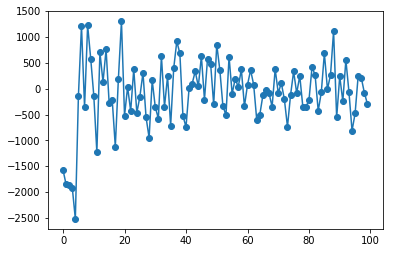

In [38]:
#idea: para cada componente principal mido covarianza con el label y miro los valores
import matplotlib.pyplot as plt

y_train_norm = y_train - y_train.mean()

ystd = np.std(y_train)
print(X_train.shape)

covarianzas = np.zeros(ALFA)
correlaciones = np.zeros(ALFA)
for i in range(ALFA):
    covarianzas[i] = ((X_train[:,i]-X_train[:,i].mean())*y_train_norm).sum()
    correlaciones[i] = covarianzas[i]/(np.std(X_train[:,i])*ystd)

plt.figure()
plt.plot(np.arange(ALFA),correlaciones,marker = "o")
plt.show()

In [40]:
K = 100

clf = sentiment.KNNClassifier(K)

clf.fit(X_train, y_train)


In [41]:
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Accuracy: {}".format(acc))

KeyboardInterrupt: 

[1 1 1 0 0 0 1 0 1 1 1 1 0 1 0 0 1 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 0 1 1 0
 1 0 1 1 0 0 1 1 0 0 1 0 0 1 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0 1 1 1 0 1
 0 1 1 0 0 1 0 0 0 1 0 1 1 1 1 0 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0
 1 1 0 1 1 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 1
 1 1 0 0 0 1 1 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 0 1 1 1 0 1 1 0 1 0 0 0 1 0
 1 1 0 1 1 1 0 0 0 1 1 1 0 1 0] [0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.
 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0.
 1. 0. 1.